# Introduction to `fastplotlib`

This notebook goes the basic components of the `fastplotlib` API, image, image updates, line plots, and scatter plots. 

In [1]:
from fastplotlib import Plot
from ipywidgets import VBox, HBox, IntSlider
import numpy as np

### Simple image

RFBOutputContext()


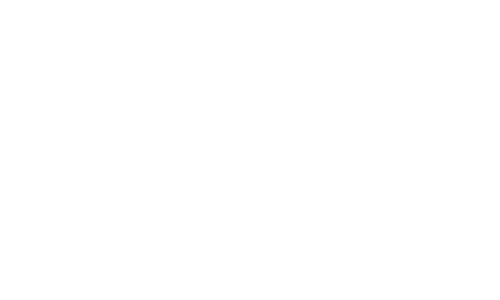

JupyterWgpuCanvas()

In [2]:
# create a `Plot` instance
plot = Plot()

# show the plot
plot.show()

In [3]:
# make some random 2D image data
data = np.random.rand(512, 512)

# add an image graphic to the plot
image_graphic = plot.add_image(data=data, name="random-image")
plot.auto_scale(maintain_aspect=True)

### Use the handle on the bottom right corner of the _canvas_ to resize it. You can also pan and zoom using your mouse!

Changing graphic "features"

In [4]:
image_graphic.cmap = "viridis"

In [5]:
image_graphic.data = 0

In [6]:
image_graphic.data[::50, :] = 1
image_graphic.data[:, ::50] = 1

In [7]:
image_graphic.data = np.random.rand(512, 512)

### Plots are indexable and give you their graphics by name

In [7]:
plot.graphics

('random-image': ImageGraphic @ 0x7fbb681a1360,)

In [8]:
plot["random-image"]

'random-image': ImageGraphic @ 0x7fbb681a1360

#### The `Graphic` instance is also returned when you call `plot.add_<graphic_type>`.

In [9]:
image_graphic

'random-image': ImageGraphic @ 0x7fbb681a1360

In [10]:
image_graphic is plot["random-image"]

True

### Image updates

This examples show how you can define animation functions that run on every render cycle.

RFBOutputContext()


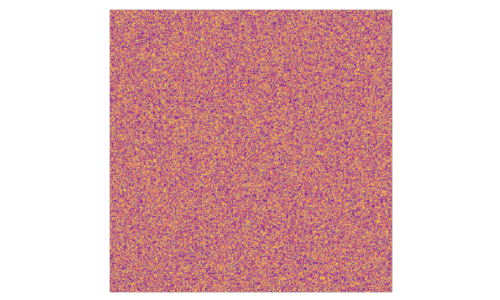

JupyterWgpuCanvas()

In [11]:
# create another `Plot` instance
plot_v = Plot()

plot.canvas.max_buffered_frames = 1

# make some random data again
data = np.random.rand(512, 512)

# plot the data
plot_v.add_image(data=data, name="random-image")

# a function to update the image_graphic
# a plot will pass its plot instance to the animation function as an arugment
def update_data(plot_instance):
    new_data = np.random.rand(512, 512)
    plot_instance["random-image"].data = new_data

#add this as an animation function
plot_v.add_animations(update_data)

# show the plot
plot_v.show()

### We can share controllers across plots

This example creates a new plot, but it synchronizes the pan-zoom controller

RFBOutputContext()


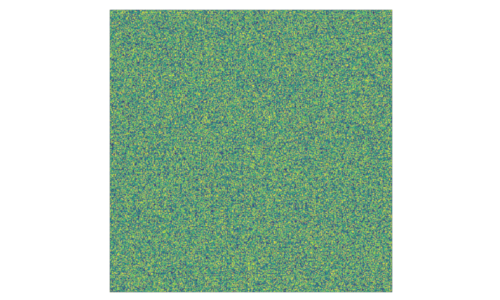

JupyterWgpuCanvas()

In [12]:
plot_sync = Plot(controller=plot_v.controller)

data = np.random.rand(512, 512)

image_graphic_instance = plot_sync.add_image(data=data, cmap="viridis")

# you will need to define a new animation function for this graphic
def update_data_2():
    new_data = np.random.rand(512, 512)
    # alternatively, you can use the stored reference to the graphic as well instead of indexing the Plot
    image_graphic_instance.data = new_data

plot_sync.add_animations(update_data_2)

plot_sync.show()

#### Keeping a reference to the Graphic instance, as shown above `image_graphic_instance`, is useful if you're creating something where you need flexibility in the naming of the graphics

### You can also use `ipywidgets.VBox` and `HBox` to stack plots. See the `gridplot` notebooks for a proper gridplot interface for more automated subplotting

In [13]:
VBox([plot_v.show(), plot_sync.show()])

# Please note that `HBox` can be buggy and crash the kernel, avoid using it
### This is an upstream issue in `jupyter-rfb`

In [14]:
HBox([plot_v.show(), plot_sync.show()])

# Sliders to scroll through image data

We often already have large image arrays (whether in RAM or through lazy loading), and want to view 2D frames across one or more dimensions. There is an `ImageWidget` that should really be used for this, but this example just shows how you can use `ipywidgets` to change data or any **`GraphicFeature`**

### Some code to generate a bunch of time-varying Gaussians. This code is NOT important for understanding `fastplotlib`, it just generates some video-like data for us to visualize!

In [15]:
import numpy as np
from scipy.stats import multivariate_normal

# set up gaussians centered at component_centers
n_frames = 1000
spatial_dims = 512

frame_shape = [512, 512]

n_components = 32
component_centers = (np.random.rand(n_components, 2) * spatial_dims).astype(int)

# create component images: stack of images one for ech component
spatial_sigma = 50
x, y = np.meshgrid(
    np.arange(0, spatial_dims),
    np.arange(0, spatial_dims)
)

pos = np.dstack((x, y))
component_sigma = np.array(
    [[spatial_sigma, 0],
     [0, spatial_sigma]]
)

component_images = []
for comp_ix in range(n_components):
    comp_mean = component_centers[comp_ix]
    gauss_rep = multivariate_normal(comp_mean, component_sigma)
    gauss_img = gauss_rep.pdf(pos)
    component_images.append(gauss_img)

component_images = np.array(component_images)


# generate traces
tau = 10
max_amp = 2000
amps_all = []

for component_num in range(n_components):
    amps = []
    amp = 0
    for time_step in np.arange(n_frames):
        if np.random.uniform(0,1) > 0.98:
            amp = max_amp
        else:
            amp = np.max(np.array([amp - amp/tau, 0]));
        amps.append(amp)
    amps = np.array(amps)
    amps_all.append(amps)
amps_all = np.array(amps_all)

# create movie
movie = np.zeros((n_frames, spatial_dims, spatial_dims))
for frame_ix in np.arange(n_frames):
    for comp_ix in range(n_components):
        movie[frame_ix] += amps_all[comp_ix][frame_ix] * component_images[comp_ix]

### The point is, we have a movie of the following shape, an image sequence

In [16]:
movie.shape

(1000, 512, 512)

### This is usually [time, x, y]

## Plot and scroll through the first dimension with a slider

In [17]:
plot_movie = Plot()

# plot the first frame to initialize
movie_graphic = plot_movie.add_image(movie[0], vmin=0, vmax=movie.max(), cmap="gnuplot2")

# make a slider
slider = IntSlider(min=0, max=movie.shape[0] - 1, step=1, value=0)

# function to update movie_graphic
def update_movie(change):
    global movie
    global movie_graphic
    
    index = change["new"]
    movie_graphic.data = movie[index]
    
slider.observe(update_movie, "value")
    
# Use an ipywidgets VBox to show the plot and slider
VBox([plot_movie.show(), slider])

RFBOutputContext()

#### Note that the use of globals in the `update_movie()` here can get messy, this is not recommended and  you should create a class to properly handle combining widgets like this. _However_ if you want slider widgets for imaging data the recommended way to do this is by using the `ImageWidget`, see the `image_widget.ipynb` notebook for details.

# Line plots

## 2D line plots

This example plots a sine wave, cosine wave, and ricker wavelet and demonstrates how **Graphic Features** can be modified by slicing!

### First generate some data.

In [18]:
# linspace, create 100 evenly spaced x values from -10 to 10
xs = np.linspace(-10, 10, 100)
# sine wave
ys = np.sin(xs)
sine = np.dstack([xs, ys])[0]

# cosine wave
ys = np.cos(xs) + 5
cosine = np.dstack([xs, ys])[0]

# sinc function
a = 0.5
ys = np.sinc(xs) * 3 + 8
sinc = np.dstack([xs, ys])[0]

### We will plot all of it on the same plot. Each line plot will be an individual Graphic, you can have any combination of graphics on a plot.

RFBOutputContext()


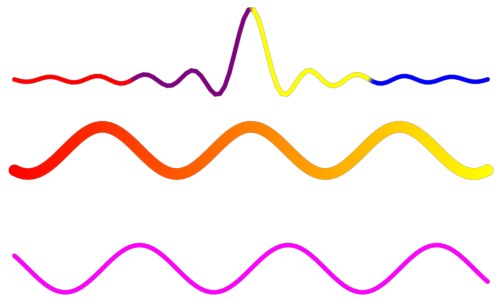

JupyterWgpuCanvas()

In [19]:
# Create a plot instance
plot_l = Plot()

# plot sine wave, use a single color
sine_graphic = plot_l.add_line(data=sine, thickness=5, colors="magenta")

# you can also use colormaps for lines!
cosine_graphic = plot_l.add_line(data=cosine, thickness=12, cmap="autumn")

# or a list of colors for each datapoint
colors = ["r"] * 25 + ["purple"] * 25 + ["y"] * 25 + ["b"] * 25
sinc_graphic = plot_l.add_line(data=sinc, thickness=5, colors = colors)

plot_l.show()

## Graphic features support slicing! :D 

In [20]:
# indexing of colors
cosine_graphic.colors[:15] = "magenta"
cosine_graphic.colors[90:] = "red"
cosine_graphic.colors[60] = "w"

# indexing to assign colormaps to entire lines or segments
sinc_graphic.cmap[10:50] = "gray"
sine_graphic.cmap = "seismic"

# more complex indexing, set the blue value directly from an array
cosine_graphic.colors[65:90, 0] = np.linspace(0, 1, 90-65)

## You can capture changes to a graphic feature as events

In [21]:
def callback_func(event_data):
    print(event_data)

# Will print event data when the color changes
cosine_graphic.colors.add_event_handler(callback_func)

In [22]:
# more complex indexing of colors
# from point 15 - 30, set every 3rd point as "cyan"
cosine_graphic.colors[15:50:3] = "cyan"

FeatureEvent @ 0x7fbacc955060
type: colors
pick_info: {'index': range(15, 50, 3), 'collection-index': None, 'world_object': <pygfx.Line at 0x7fbacc9b0dc0>, 'new_data': array([[0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.]], dtype=float32)}



## Graphic _data_ is itself also indexable

In [23]:
cosine_graphic.data[10:50:5, :2] = sine[10:50:5]
cosine_graphic.data[90:, 1] = 7

In [24]:
cosine_graphic.data[0] = np.array([[-10, 0, 0]])

### Toggle the presence of a graphic within the scene

In [25]:
sinc_graphic.present = False

In [26]:
sinc_graphic.present = True

### You can create callbacks to this too, for example to re-scale the plot w.r.t. graphics that are present in the scene

In [27]:
sinc_graphic.present.add_event_handler(plot_l.auto_scale)

In [28]:
sinc_graphic.present = False

In [29]:
sinc_graphic.present = True

### 3D line plot

RFBOutputContext()

/home/kushalk/repos/fastplotlib/fastplotlib/layouts/_base.py:214: UserWarning: `center_scene()` not yet implemented for `PerspectiveCamera`
  warn("`center_scene()` not yet implemented for `PerspectiveCamera`")



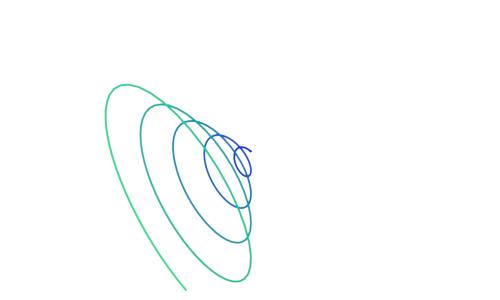

JupyterWgpuCanvas()

In [30]:
# just set the camera as "3d", the rest is basically the same :D 
plot_l3d = Plot(camera='3d')

# create a spiral
phi = np.linspace(0, 30, 200)

xs = phi * np.cos(phi)
ys = phi * np.sin(phi)
zs = phi

# use 3D data
# note: you usually mix 3D and 2D graphics on the same plot
spiral = np.dstack([xs, ys, zs])[0]

plot_l3d.add_line(data=spiral, thickness=2, cmap='winter')

plot_l3d.show()

# Scatter plots

### Plot tens of thousands or millions of points

#### There might be a small delay for a few seconds before the plot shows, this is due to shaders being compiled and a few other things. The plot should be very fast and responsive once it is displayed and future modifications should also be fast!

In [31]:
from fastplotlib import Plot
from ipywidgets import VBox, HBox, IntSlider
import numpy as np

RFBOutputContext()


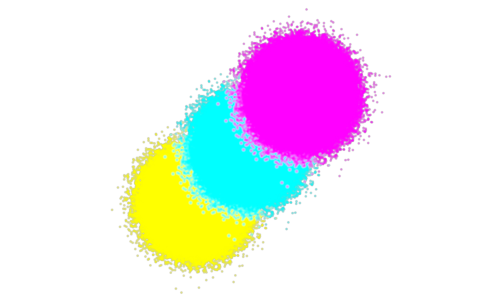

JupyterWgpuCanvas()

In [32]:
# create a random distribution of 10,000 xyz coordinates
n_points = 10_000

# if you have a good GPU go for 1.5 million points :D 
# this is multiplied by 3
n_points = 500_000

# dimensions always have to be [n_points, xyz]
dims = (n_points, 3)

clouds_offset = 15

# create some random clouds
normal = np.random.normal(size=dims, scale=5)
# stack the data into a single array
cloud = np.vstack(
    [
        normal - clouds_offset,
        normal,
        normal + clouds_offset,
    ]
)

# color each of them separately
colors = ["yellow"] * n_points + ["cyan"] * n_points + ["magenta"] * n_points

# create plot
plot_s = Plot()

# use an alpha value since this will be a lot of points
scatter_graphic = plot_s.add_scatter(data=cloud, sizes=3, colors=colors, alpha=0.7)

plot_s.show()

### scatter graphic features work similarly to line graphic

In [35]:
# half of the first cloud's points to red
scatter_graphic.colors[:n_points:2] = "r"

In [36]:
# set the green value directly
scatter_graphic.colors[n_points:n_points * 2, 1] = 0.3

In [37]:
# set color values directly using an array
scatter_graphic.colors[n_points * 2:] = np.repeat([[1, 1, 0, 0.5]], n_points, axis=0)

In [38]:
# change the data, change y-values
scatter_graphic.data[n_points:n_points * 2, 1] += 15

In [39]:
# set x values directly but using an array
scatter_graphic.data[n_points:n_points * 2, 0] = np.linspace(-40, 0, n_points)

### You can combine VBox and HBox to create more complex layouts

This just plots everything above in a single nb output

In [40]:
row1 = HBox([plot.show(), plot_v.show(), plot_sync.show()])
row2 = HBox([plot_l.show(), plot_l3d.show(), plot_s.show()])

VBox([row1, row2])